In [1]:
!unzip -q /content/models_predictions.zip -d /content/data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [4]:
csv_dir = '/content/data/models_predictions'

## Create the data

In [64]:
# Initialize a list to store the data with model information
data = []

# Loop over each CSV file in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith(".csv"):
        model_name = filename.replace(".csv", "")

        # Drop models that didn't work
        if model_name in ["google_gemma-2-27b", "google_gemma-2-27b-it"]:
          continue
        # Load the CSV file
        file_path = os.path.join(csv_dir, filename)
        df = pd.read_csv(file_path)

        # handle too long model names
        if model_name == "nvidia_Llama-3.1-Nemotron-70B-Instruct-HF":
            model_name = "nvidia_Nemotron-70B-Instruct"

        # Add a 'model' column based on the filename
        df['model'] = '_'.join(model_name.split('_')[1:])

        # Append to the list
        data.append(df)

# Concatenate all data into a single DataFrame
all_data = pd.concat(data, ignore_index=True)
all_data['is_correct_prediction'] = all_data['correct_probability'] > all_data['incorrect_probability']
all_data = all_data.sort_values(
    by=['model', 'type'],
    key=lambda col: col.str.lower()
)



In [41]:
# All the types
all_data["type"].unique()

array(['first_center_com', 'first_center_mid', 'first_center_sim',
       'first_center_sim_rev', 'second_center_com', 'second_center_mid',
       'second_center_sim', 'second_center_sim_rev'], dtype=object)

In [46]:
all_data['center_type'] = all_data['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
all_data['wording'] = all_data['type'].apply( lambda x: 'com' if x.endswith('com') else
              ('mid' if x.endswith('mid') else
               ('sim' if x.endswith('sim') else
                ('sim_rev' if x.endswith('sim_rev') else 'non_com'))
              ))

In [47]:
with_sim_rev = all_data.copy()

In [48]:
all_data = all_data[~all_data["type"].isin(["first_center_sim_rev", "second_center_sim_rev"])]

In [49]:
all_data.sort_values(by=["set_id", "model"]).head(16)

,sentence,question,set_id,type,answer,correct_option,correct_first_token,correct_probability,incorrect_option,incorrect_first_token,incorrect_probability,predicted_answer,is_correct_prediction,model,center_type,wording
3009,The child that the neighbor that the guest scared liked fell.,Who did the neighbor like?,1,first_center_com,The child,child,3124,0.511717,guest,31277,0.488283,Thechildguestchildguest,True,Llama-3.1-70B-Instruct,first_center,com
3011,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the neighbor like?,1,first_center_mid,The child,child,3124,0.953622,guest,31277,0.046378,Thechildchildchildchild,True,Llama-3.1-70B-Instruct,first_center,mid
3013,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the neighbor like?,1,first_center_sim,The child,child,3124,0.959154,guest,31277,0.040846,Thechildchildchildchild,True,Llama-3.1-70B-Instruct,first_center,sim
3008,The child that the neighbor that the guest scared liked fell.,Who did the guest scare?,1,second_center_com,The neighbor,neighbor,37569,0.258326,child,3124,0.741674,Thechildneighborneighborneighbor,False,Llama-3.1-70B-Instruct,second_center,com
3010,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the guest scare?,1,second_center_mid,The neighbor,neighbor,37569,0.307358,child,3124,0.692642,Thechildneighborneighborchild,False,Llama-3.1-70B-Instruct,second_center,mid
3012,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the guest scare?,1,second_center_sim,The neighbor,neighbor,37569,0.846958,child,3124,0.153042,Theneighborneighborneighborneighbor,True,Llama-3.1-70B-Instruct,second_center,sim
2633,The child that the neighbor that the guest scared liked fell.,Who did the neighbor like?,1,first_center_com,The child,child,3124,0.384912,guest,31277,0.615088,Theguestchildchildchild,False,Llama-3.1-8B,first_center,com
2635,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the neighbor like?,1,first_center_mid,The child,child,3124,0.626124,guest,31277,0.373876,Thechildchildchildchild,True,Llama-3.1-8B,first_center,mid
2637,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the neighbor like?,1,first_center_sim,The child,child,3124,0.875787,guest,31277,0.124213,Thechildguestchildguest,True,Llama-3.1-8B,first_center,sim
2632,The child that the neighbor that the guest scared liked fell.,Who did the guest scare?,1,second_center_com,The neighbor,neighbor,37569,0.501953,child,3124,0.498047,Theneighborchildneighborchild,True,Llama-3.1-8B,second_center,com


In [50]:
def create_groupby(df):
  accuracy_by_model_and_type = (
      df
      .groupby(['model', 'type'])['is_correct_prediction']
      .mean()
      .reset_index()
      .rename(columns={'is_correct_prediction': 'accuracy'})
  )
  # Case-insensitive sorting by multiple columns (e.g., 'model' and 'type')
  accuracy_by_model_and_type = accuracy_by_model_and_type.sort_values(
      by=['model', 'type'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)


  # Extract center type and suffix from the `type` column
  accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
  accuracy_by_model_and_type['wording'] = accuracy_by_model_and_type['type'].apply(
      lambda x: 'com' if x.endswith('com') else
                ('mid' if x.endswith('mid') else
                ('sim' if x.endswith('sim') else
                  ('sim_rev' if x.endswith('sim_rev') else 'non_com')))
  )
  return accuracy_by_model_and_type

accuracy_by_model_and_type = create_groupby(all_data)
accuracy_by_model_and_type_with_sim_rev = create_groupby(with_sim_rev)


In [ ]:
accuracy_by_model_and_type.head()

,model,type,accuracy,center_type,wording
0,gemma-2-2b,first_center_com,0.914894,first_center,com
1,gemma-2-2b,first_center_mid,0.872340,first_center,mid
2,gemma-2-2b,first_center_sim,0.914894,first_center,sim
3,gemma-2-2b,second_center_com,0.191489,second_center,com
4,gemma-2-2b,second_center_mid,0.468085,second_center,mid


In [63]:
res_dir = "/content/res"
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

## General

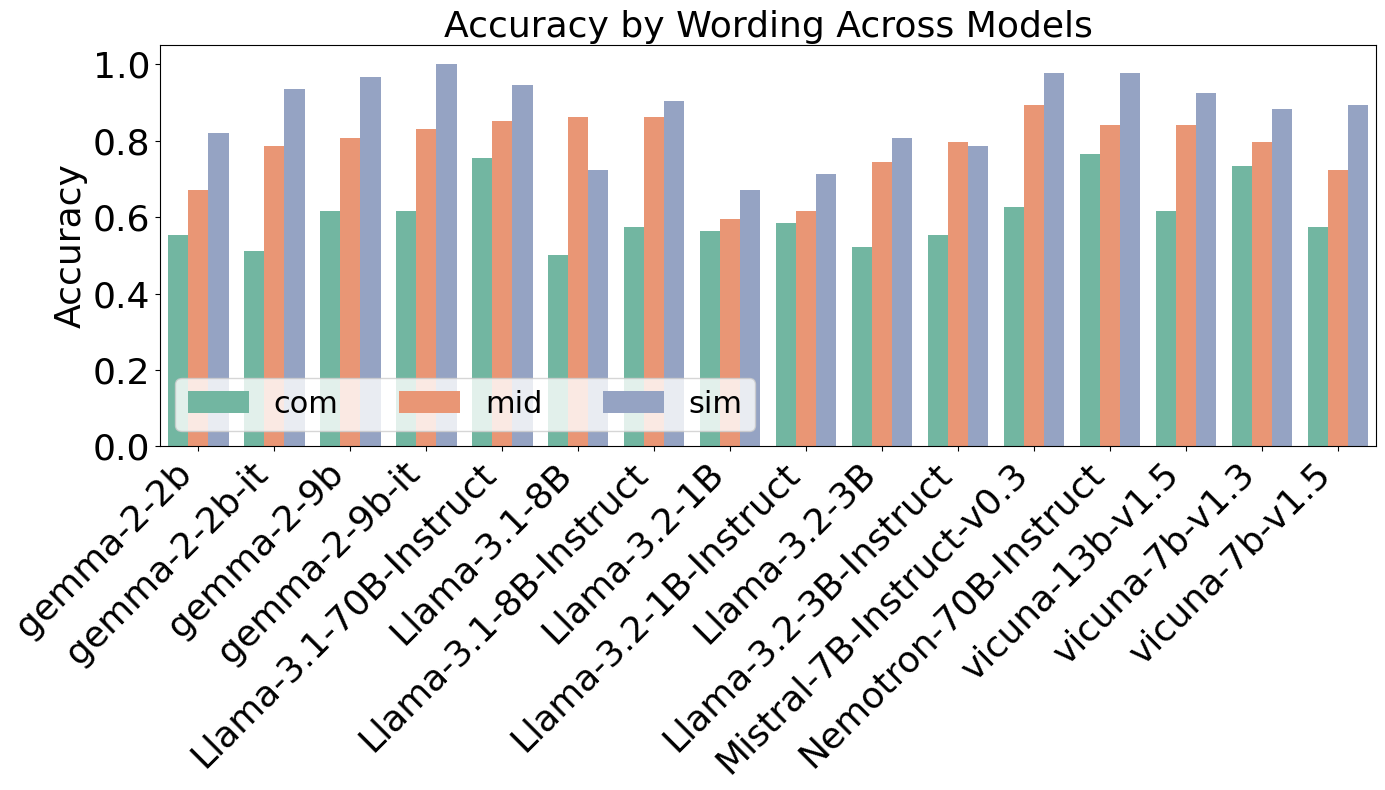

In [55]:
# Extract center type and suffix from the `type` column
#accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
#accuracy_by_model_and_type['suffix'] = accuracy_by_model_and_type['type'].apply(lambda x: '_'.join(x.split('_')[2:]))

# Calculate the average accuracy for each model, center type, and suffix
avg_accuracy = accuracy_by_model_and_type.groupby(['model', 'wording'])['accuracy'].mean().reset_index()
avg_accuracy = avg_accuracy.sort_values(
    by=['model', 'wording'],
    key=lambda col: col.str.lower(),
).reset_index(drop=True)

# Set up the figure
plt.figure(figsize=(14, 8))

# Create the bar plot
sns.barplot(
    data=avg_accuracy,
    x='model',
    y='accuracy',
    hue='wording',  # Combining center type and suffix for color coding
    palette='Set2'
)

# Customize the plot
title = 'Accuracy by Wording Across Models'
plt.title(title, fontsize='26')
plt.xlabel('')
plt.ylabel('Accuracy', fontsize='26')
plt.legend(loc='lower left', fontsize='22', ncol=3)
plt.xticks(rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)

# Save figure
filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
file_path = os.path.join(res_dir, filename)
plt.savefig(file_path)


# Show plot
plt.tight_layout()
plt.show()

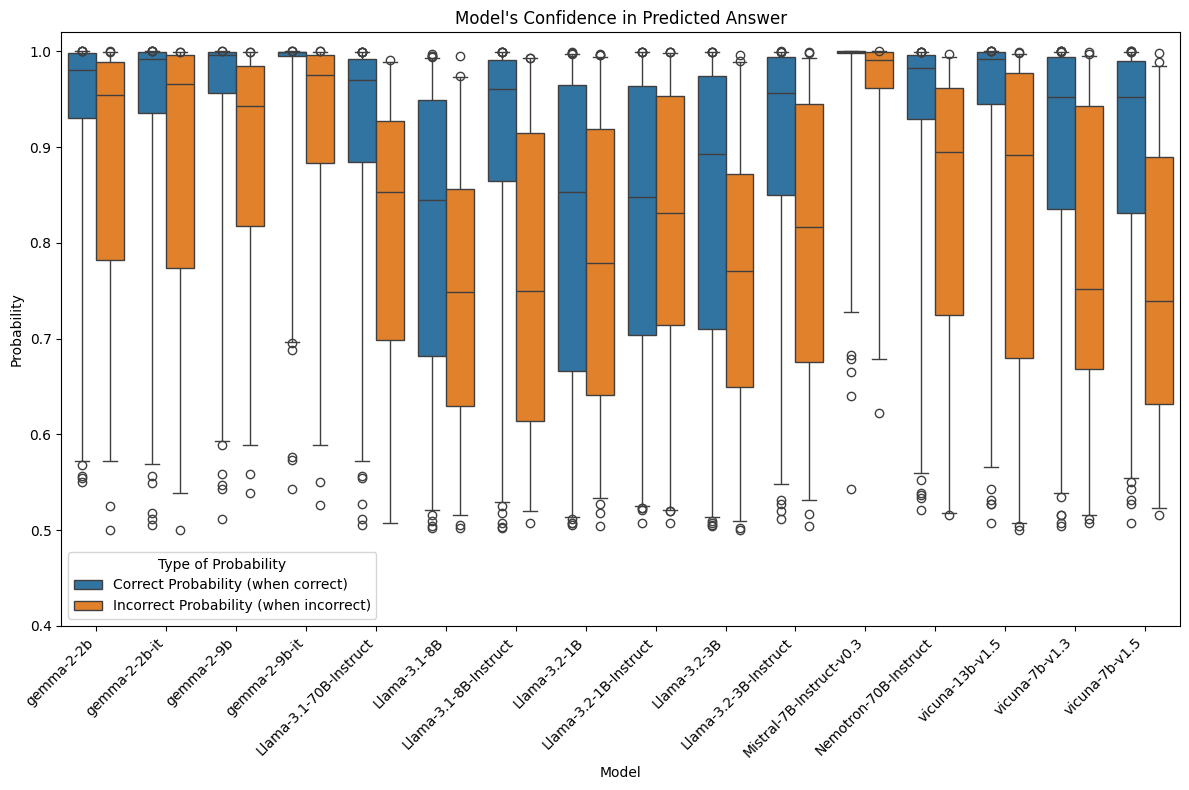

In [56]:
# Filter data for correct and incorrect predictions
correct_data = all_data[all_data['is_correct_prediction'] == True][['model', 'correct_probability']]
incorrect_data = all_data[all_data['is_correct_prediction'] == False][['model', 'incorrect_probability']]

# Rename columns for consistency in plotting
correct_data = correct_data.rename(columns={'correct_probability': 'probability'})
incorrect_data = incorrect_data.rename(columns={'incorrect_probability': 'probability'})

# Add a column indicating the type of probability
correct_data['type'] = 'Correct Probability (when correct)'
incorrect_data['type'] = 'Incorrect Probability (when incorrect)'

# Combine the two datasets
plot_data = pd.concat([correct_data, incorrect_data], ignore_index=True)
plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a boxplot
sns.boxplot(
    data=plot_data,
    x='model',
    y='probability',
    hue='type',
    dodge=True,
    whis=[2,98]
)
plt.title('Model\'s Confidence in Predicted Answer')
plt.xlabel('Model')
plt.ylabel('Probability')
plt.legend(title='Type of Probability')
plt.ylim(0.4,1.02)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
plot_data.head()

,model,probability,type
0,gemma-2-2b,0.837620,Correct Probability (when correct)
1,gemma-2-2b,0.916708,Correct Probability (when correct)
2,gemma-2-2b,0.991084,Correct Probability (when correct)
3,gemma-2-2b,0.930458,Correct Probability (when correct)
4,gemma-2-2b,0.554470,Correct Probability (when correct)


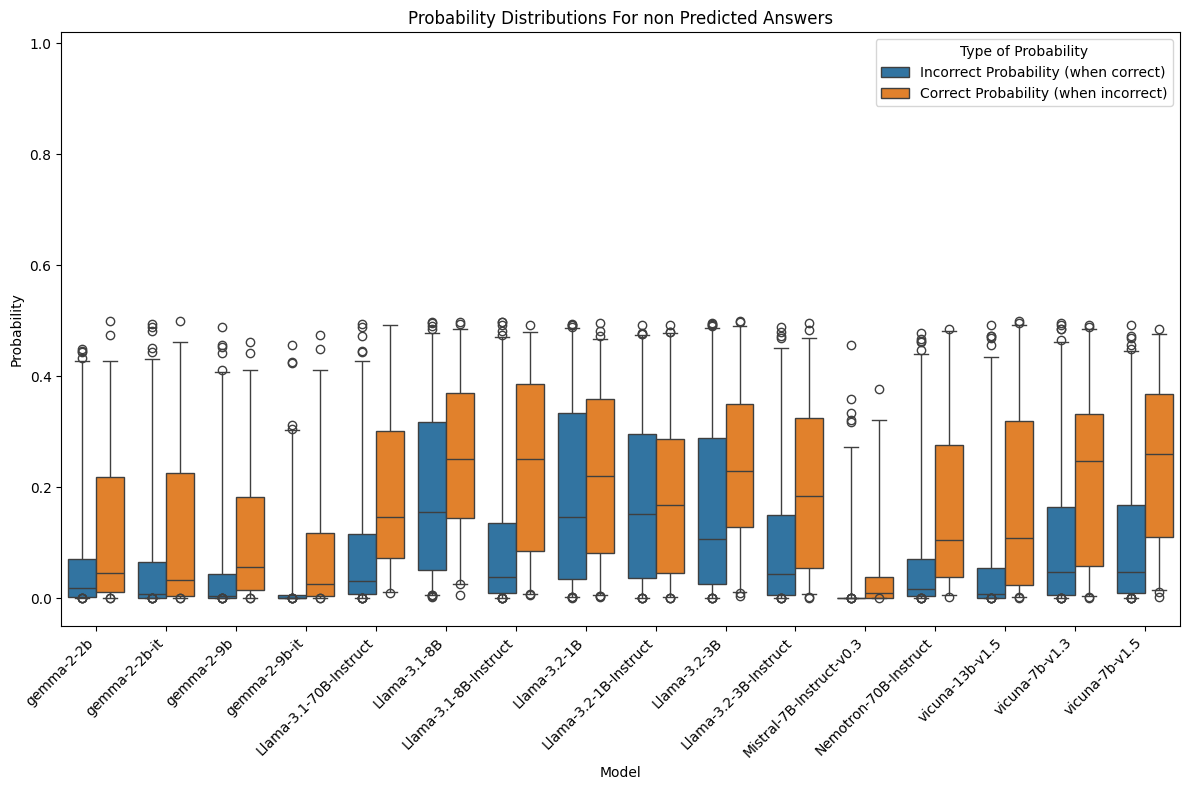

In [57]:
# Filter data for correct and incorrect predictions
correct_data = all_data[all_data['is_correct_prediction'] == True][['model', 'incorrect_probability']]
incorrect_data = all_data[all_data['is_correct_prediction'] == False][['model', 'correct_probability']]

# Rename columns for consistency in plotting
correct_data = correct_data.rename(columns={'incorrect_probability': 'probability'})
incorrect_data = incorrect_data.rename(columns={'correct_probability': 'probability'})

# Add a column indicating the type of probability
correct_data['type'] = 'Incorrect Probability (when correct)'
incorrect_data['type'] = 'Correct Probability (when incorrect)'

# Combine the two datasets
plot_data = pd.concat([correct_data, incorrect_data], ignore_index=True)
plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a boxplot
sns.boxplot(
    data=plot_data,
    x='model',
    y='probability',
    hue='type',
    dodge=True,
    whis=[2,98]
)
plt.title('Probability Distributions For non Predicted Answers')
plt.xlabel('Model')
plt.ylabel('Probability')
plt.legend(title='Type of Probability')
plt.ylim(-0.05,1.02)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Com vs Non-Com

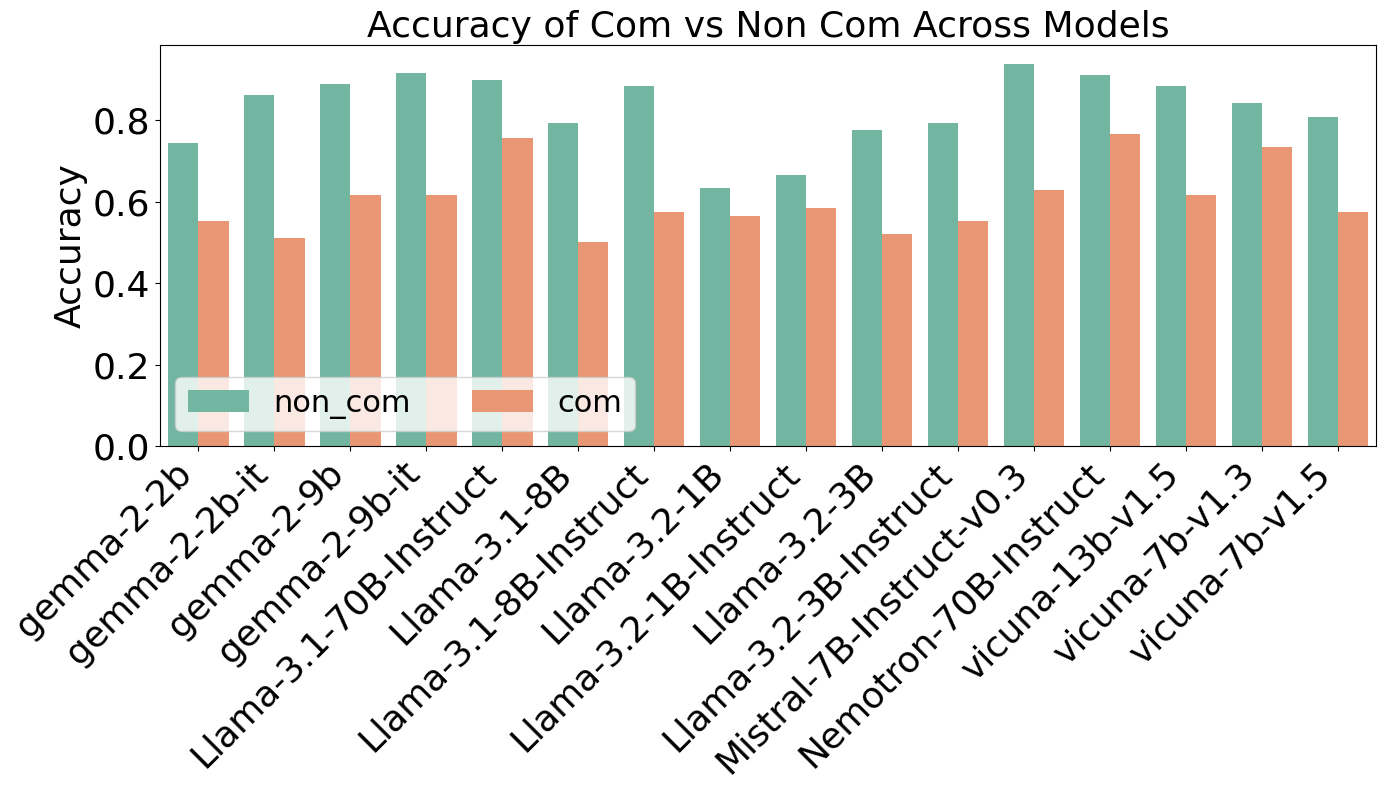

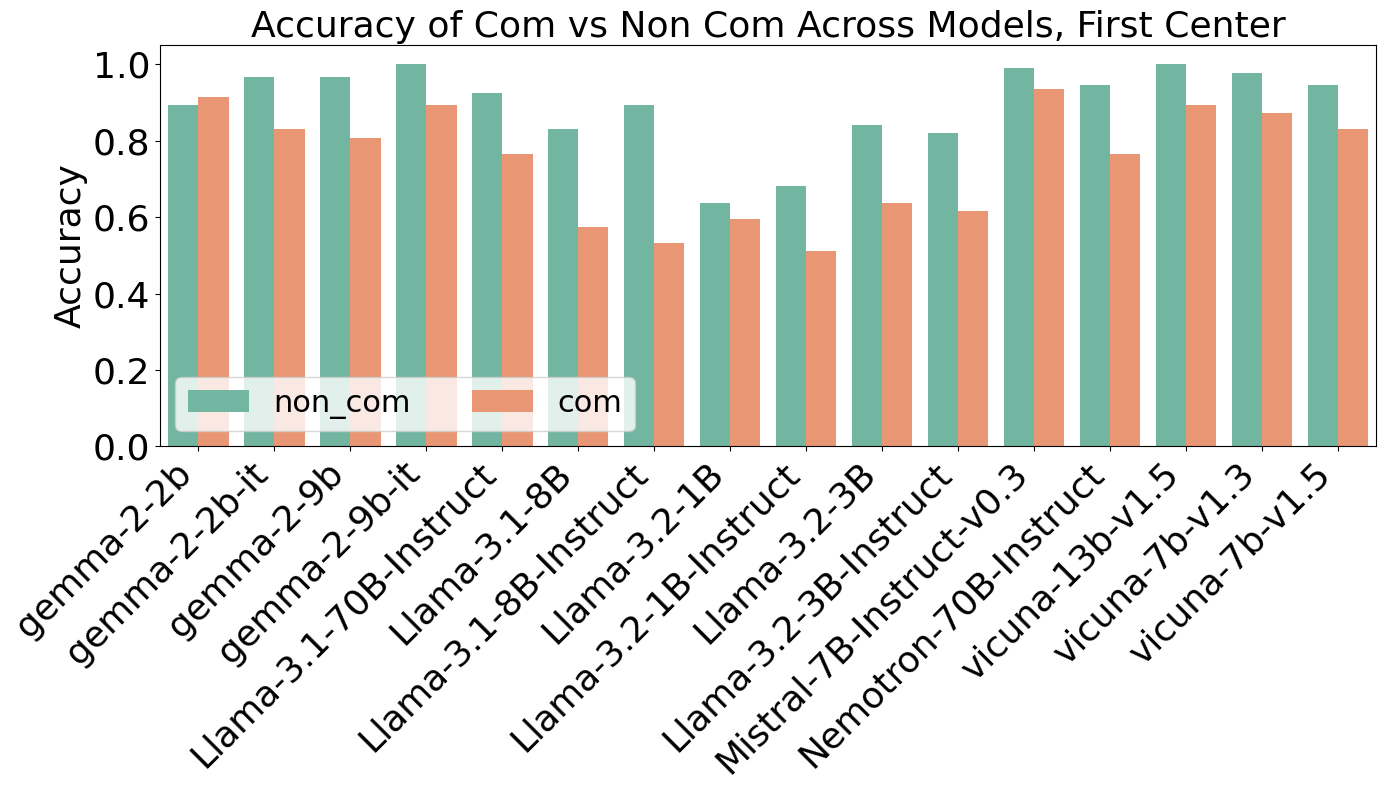

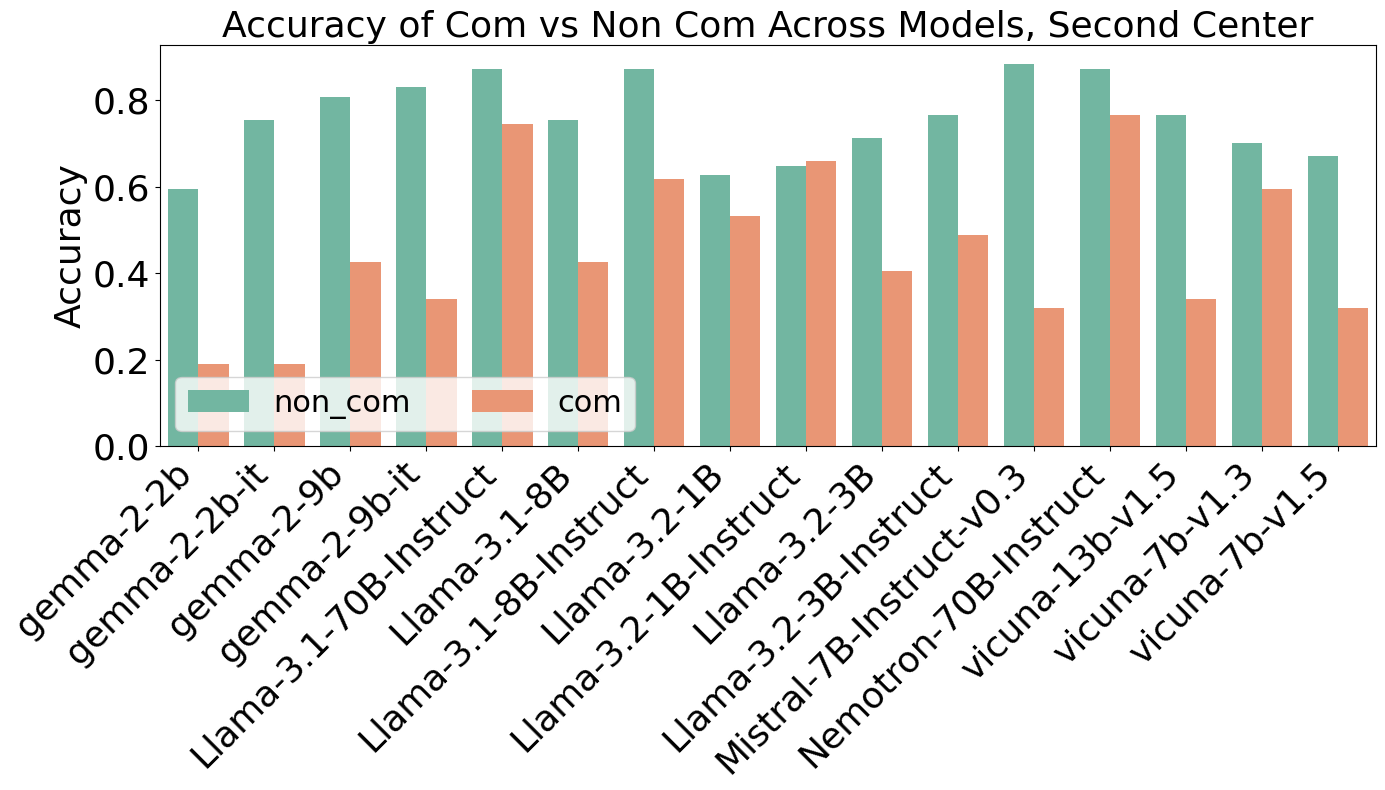

In [62]:
# Draw accuracy separated by center

# Extract center type and suffix from the `type` column
accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
accuracy_by_model_and_type['wording_com'] = accuracy_by_model_and_type['type'].apply(lambda x: 'com' if 'com' in x else 'non_com')

def plot_accuracy_per_model(grouped_df, title):

  # Calculate the average accuracy for each model, center type, and suffix
  avg_accuracy = grouped_df.groupby(['model', 'wording_com'])['accuracy'].mean().reset_index()
  avg_accuracy = avg_accuracy.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the figure
  plt.figure(figsize=(14, 8))

  # Create the bar plot
  sns.barplot(
      data=avg_accuracy,
      x='model',
      y='accuracy',
      hue='wording_com',  # Combining center type and wording for color coding
      palette='Set2'
  )

  # Customize the plot
  plt.title(title, fontsize=26)
  plt.xlabel('')
  plt.ylabel('Accuracy', fontsize=26)
  plt.legend(loc='lower left', fontsize=22, ncols=2)
  plt.xticks(rotation=45, ha='right', fontsize=26)
  plt.yticks(fontsize=26)

  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)

  # Show plot
  plt.tight_layout()
  plt.show()

plot_accuracy_per_model(accuracy_by_model_and_type, 'Accuracy of Com vs Non Com Across Models')
first_center = accuracy_by_model_and_type[accuracy_by_model_and_type['center_type'] == "first_center"]
second_center = accuracy_by_model_and_type[accuracy_by_model_and_type['center_type'] == "second_center"]
plot_accuracy_per_model(first_center, title='Accuracy of Com vs Non Com Across Models, First Center')
plot_accuracy_per_model(second_center, title='Accuracy of Com vs Non Com Across Models, Second Center')

In [ ]:
def confidence_com_non_com(all_data, isRight, filter= None):
  title_end=" (Com vs Non Com)"
  if filter== "first":
    all_data=all_data[all_data['center_type'] == 'first_center']
    title_end= " First Center"
  elif filter== "second":
     all_data=all_data[all_data['center_type'] == 'second_center']
     title_end= " Second Center"
  # Filter data for correct and incorrect predictions
  prob = 'correct_probability' if isRight else 'incorrect_probability'
  com_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['wording'] == 'com')][['model', prob]]
  non_com_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['wording'].isin(['sim', 'mid']))][['model', prob]]

  # Rename columns for consistency in plotting
  com_data = com_data.rename(columns={prob: 'probability'})
  non_com_data = non_com_data.rename(columns={prob: 'probability'})

  # Add a column indicating the type of probability
  com_data['type'] = 'Com'
  non_com_data['type'] = 'Non Com'

  # Combine the two datasets
  plot_data = pd.concat([com_data, non_com_data], ignore_index=True)
  plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the matplotlib figure
  plt.figure(figsize=(12, 8))

  # Create a boxplot
  sns.boxplot(
      data=plot_data,
      x='model',
      y='probability',
      hue='type',
      dodge=True,
      whis=[2,98]
  )
  is_right_title= "Right" if isRight else "Wrong"
  title= 'Confidence - Probability Distributions ' + is_right_title + title_end
  plt.title(title)
  plt.xlabel('Model')
  plt.ylabel('Probability')
  plt.legend(title='Type of Probability')
  plt.ylim(-0.05,1.02)
  plt.xticks(rotation=45, ha='right', fontsize=10)


  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)


  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()



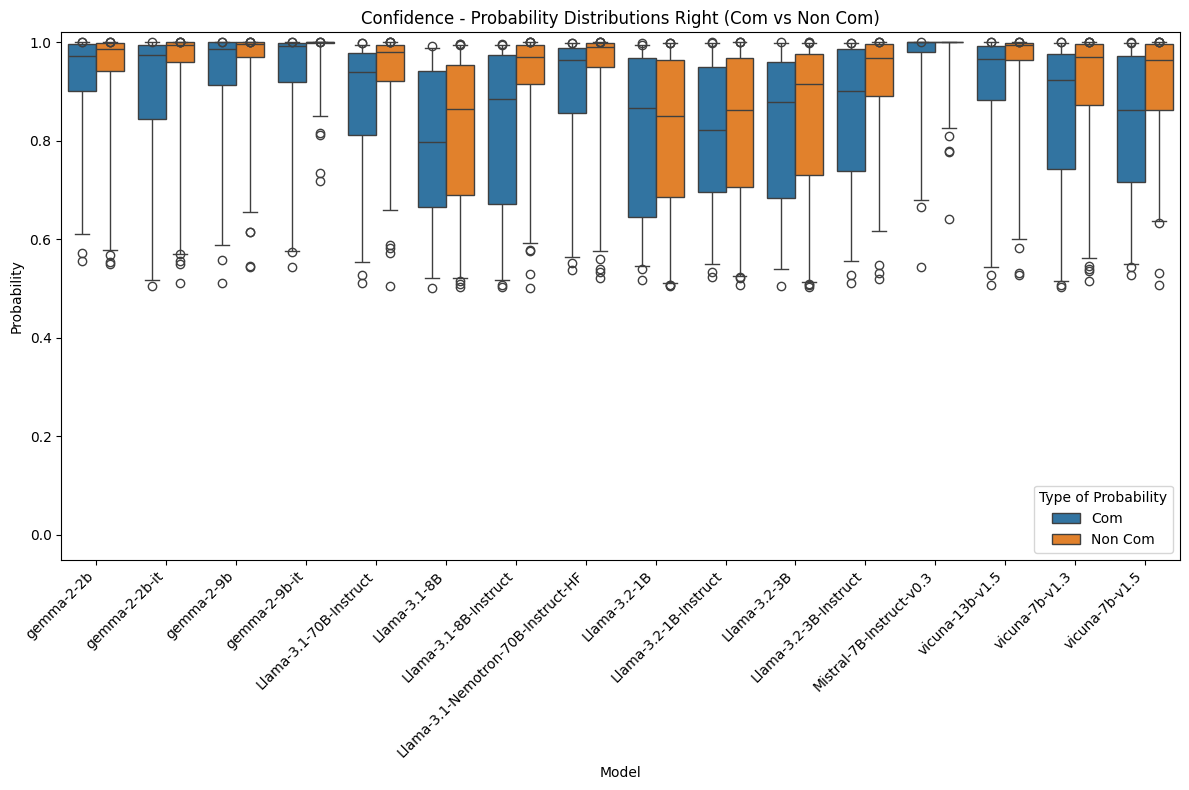

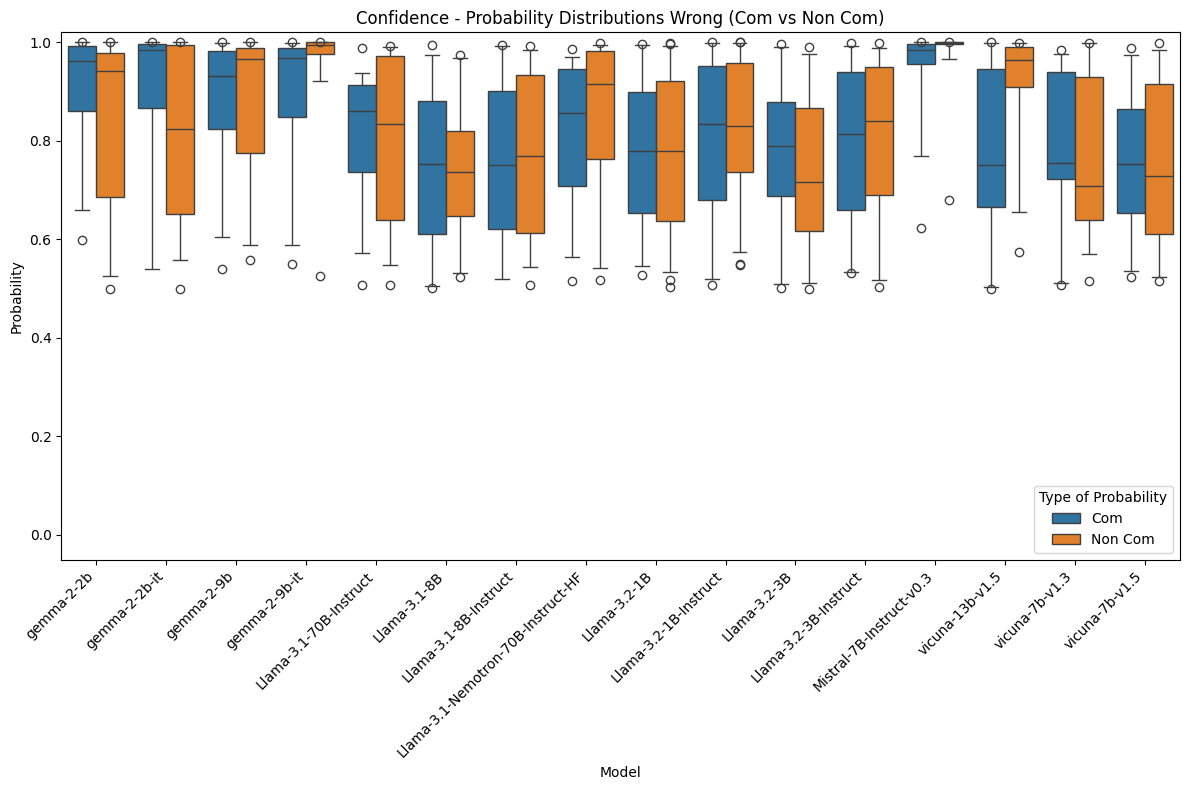

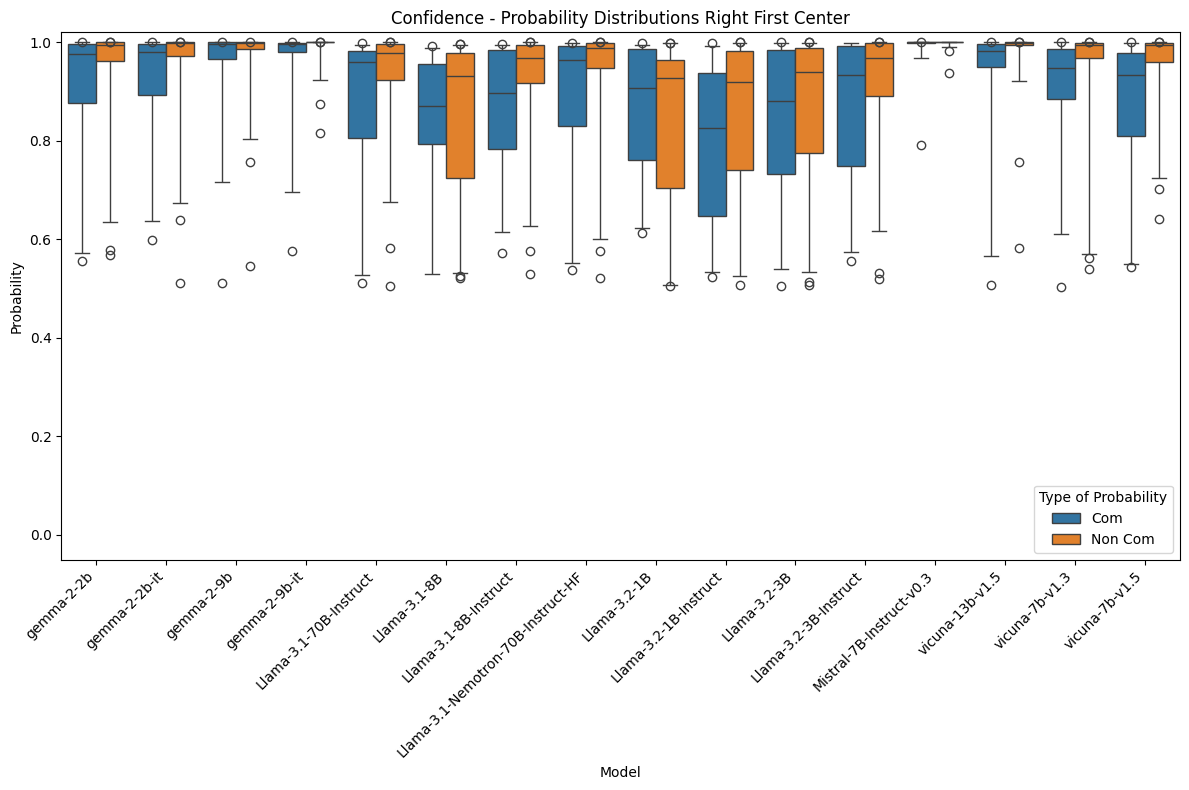

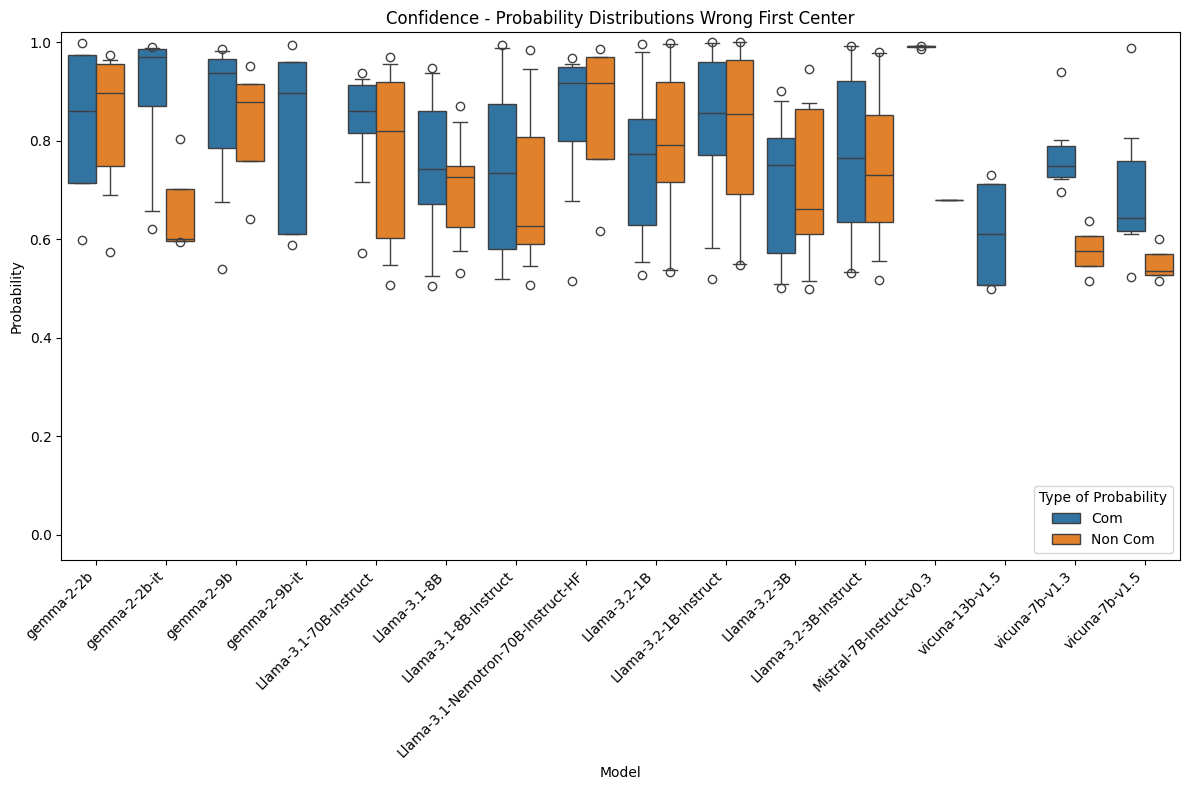

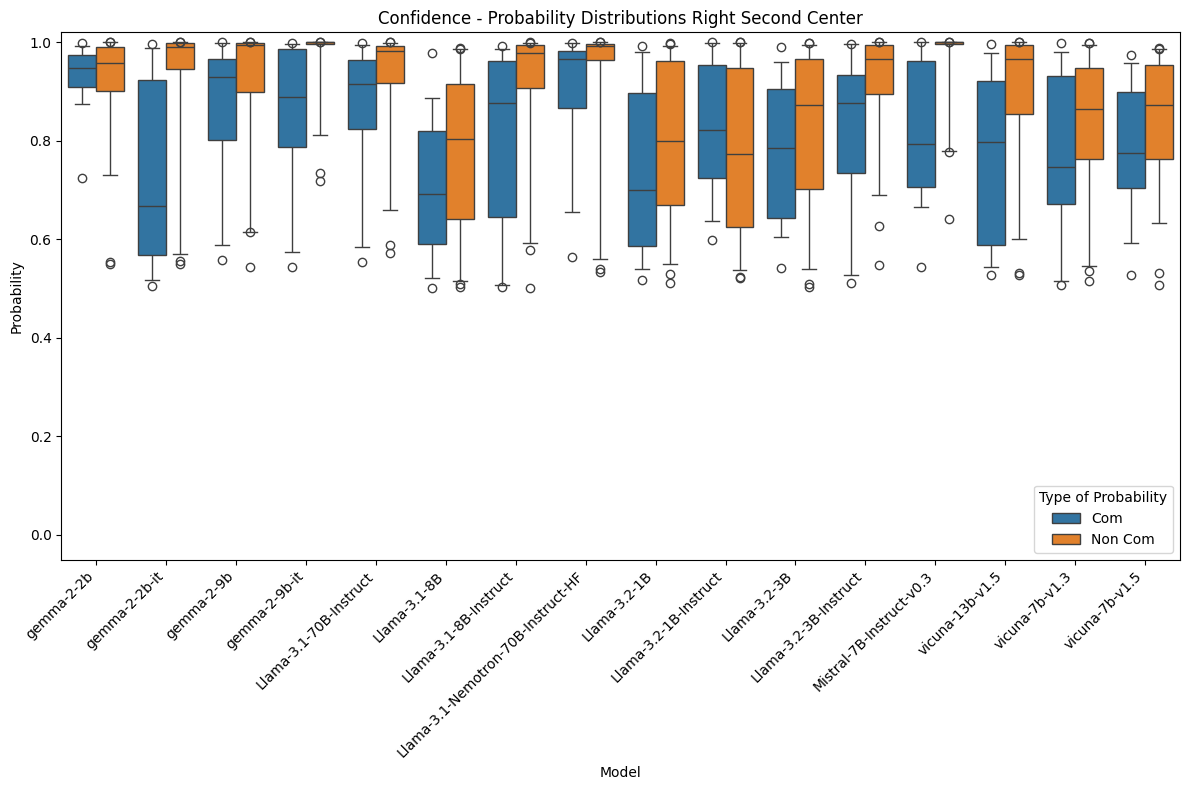

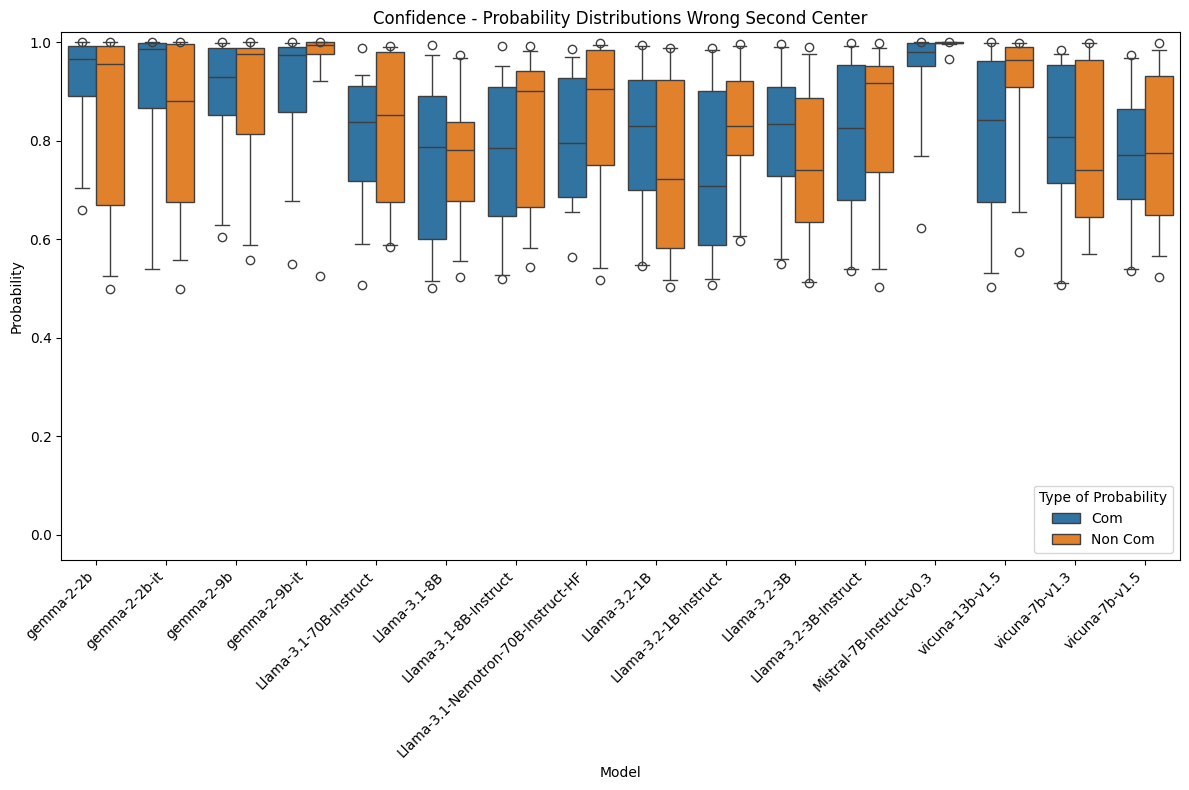

In [ ]:

confidence_com_non_com(all_data=all_data,isRight=True)
confidence_com_non_com(all_data=all_data,isRight=False)
confidence_com_non_com(all_data=all_data, isRight=True,filter= "first")
confidence_com_non_com(all_data=all_data, isRight=False, filter="first")
confidence_com_non_com(all_data=all_data, isRight=True, filter="second")
confidence_com_non_com(all_data=all_data, isRight=False, filter="second")



## First Center vs Second Center

In [ ]:
accuracy_by_model_and_type.head()

,model,type,accuracy,center_type,wording,wording_com
0,gemma-2-2b,first_center_com,0.914894,first_center,com,com
1,gemma-2-2b,first_center_mid,0.872340,first_center,mid,non_com
2,gemma-2-2b,first_center_sim,0.914894,first_center,sim,non_com
3,gemma-2-2b,second_center_com,0.191489,second_center,com,com
4,gemma-2-2b,second_center_mid,0.468085,second_center,mid,non_com


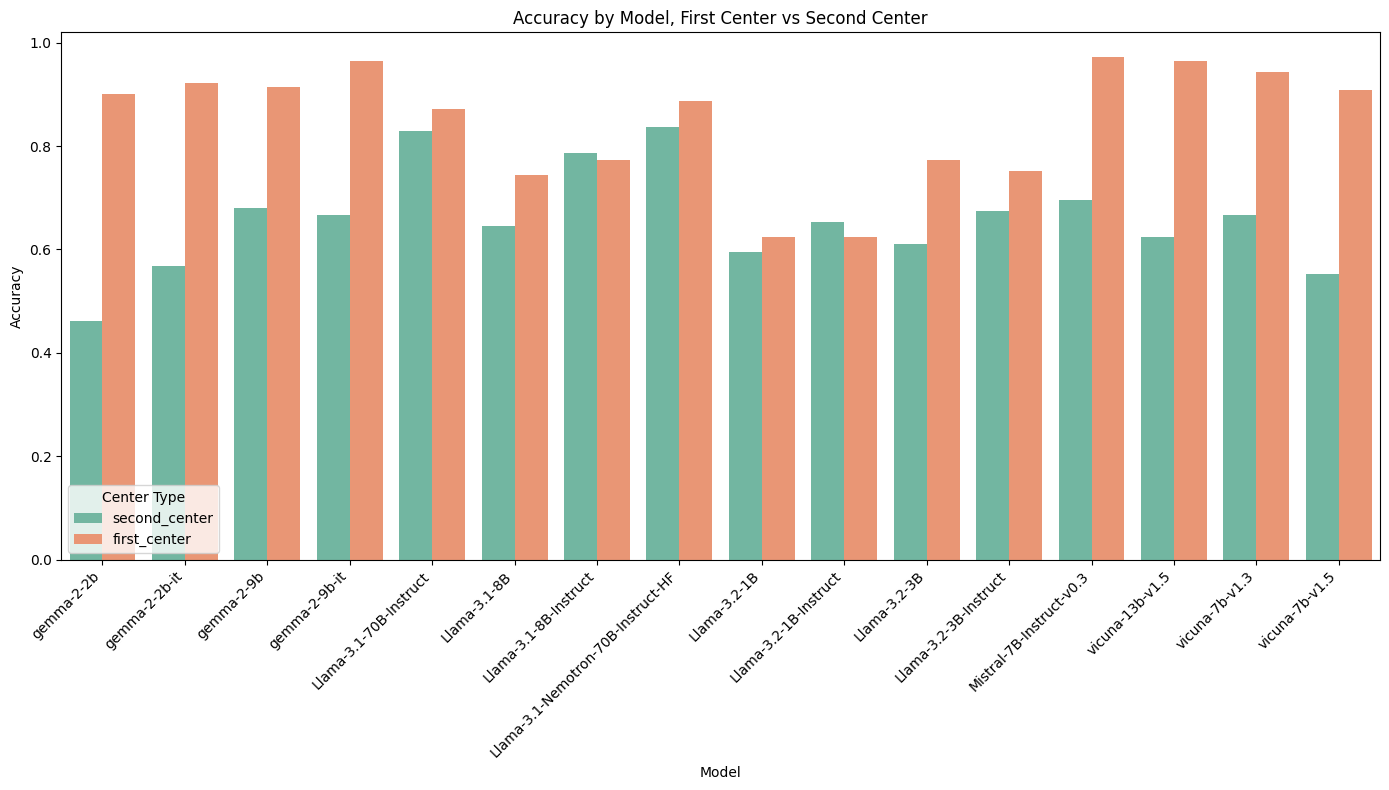

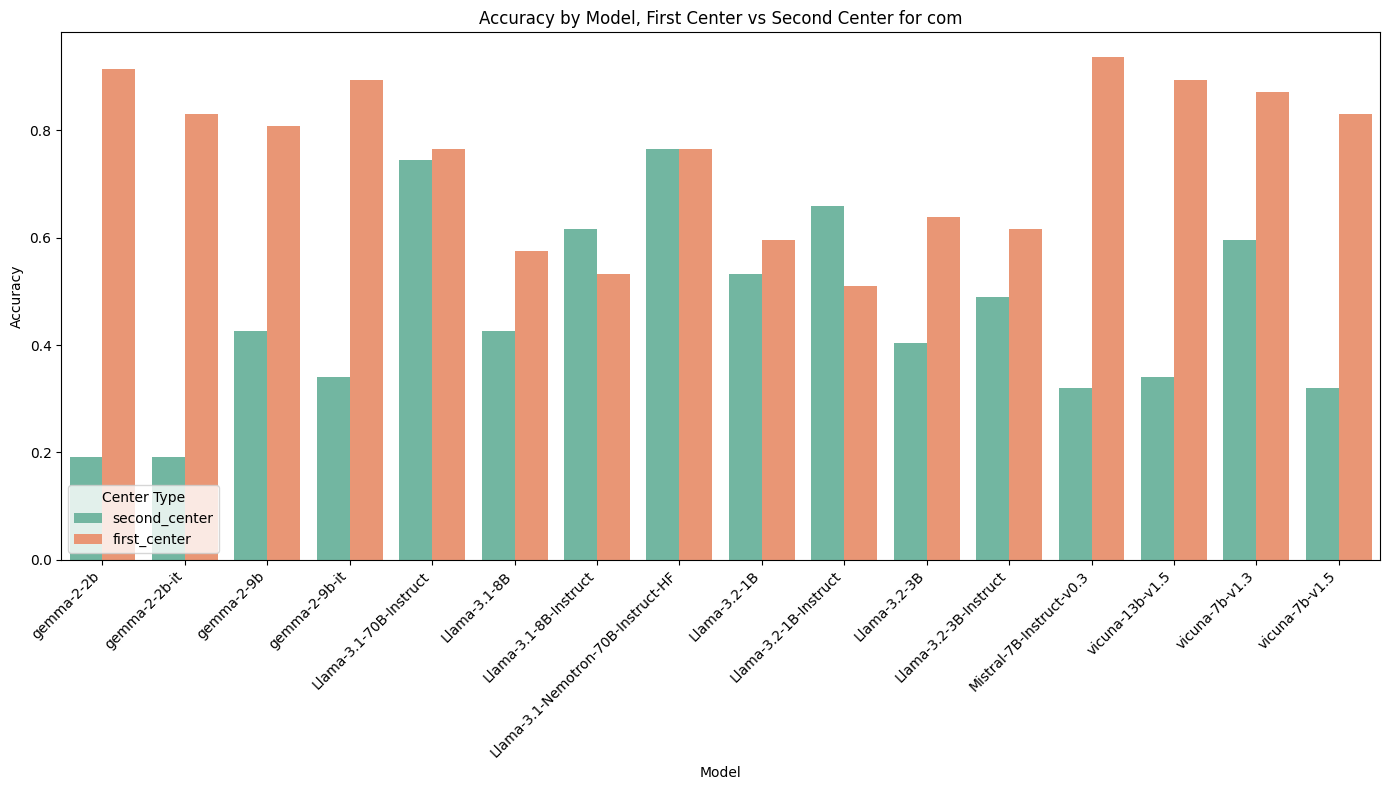

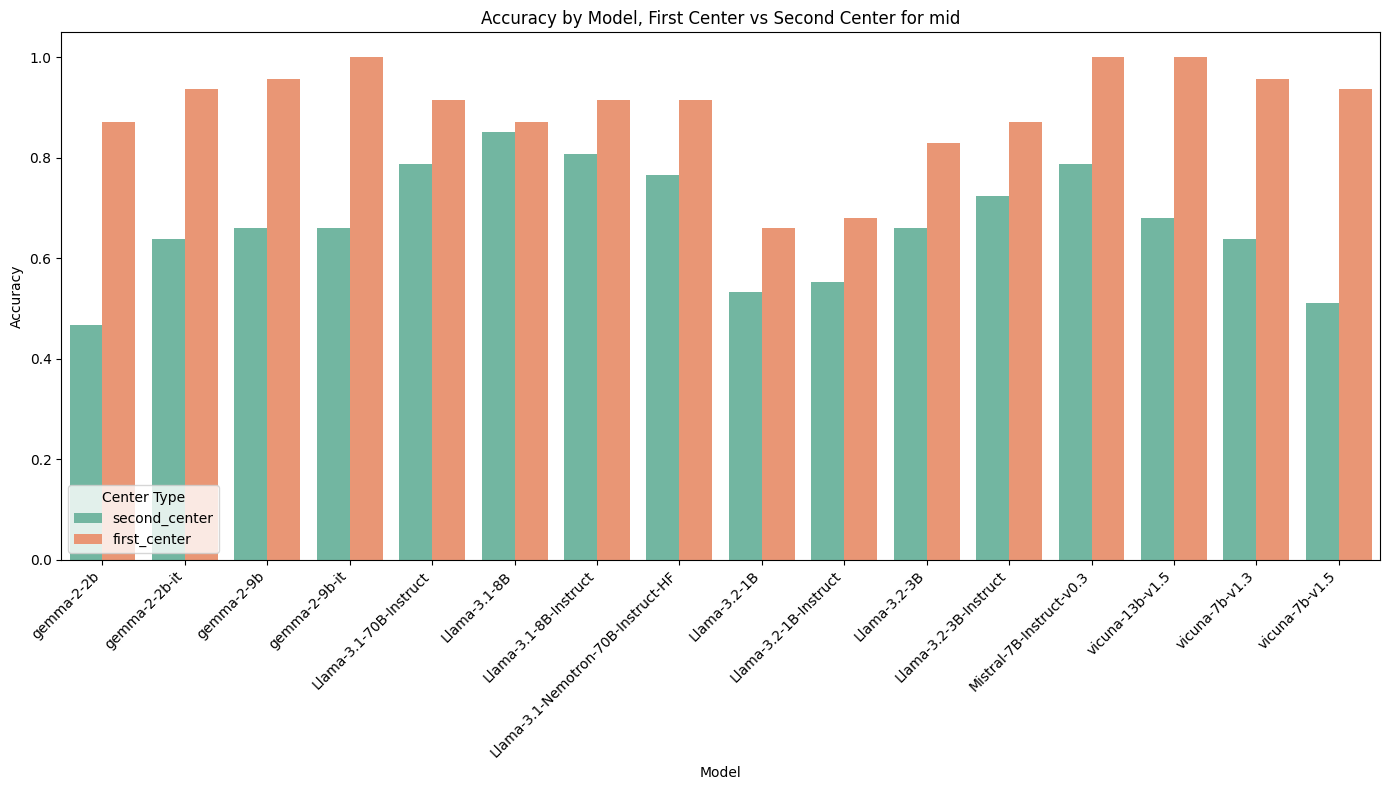

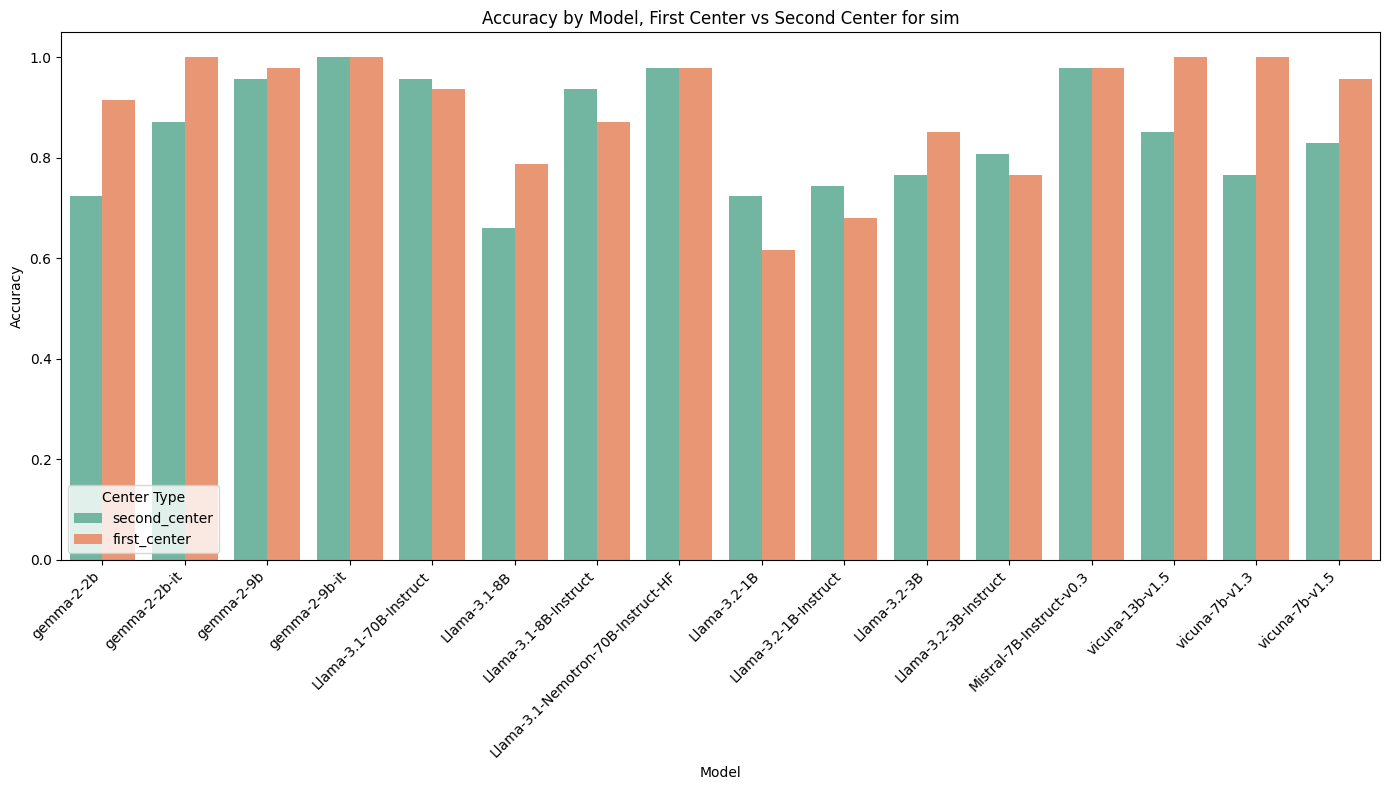

In [ ]:
# Draw accuracy separated by center


def plot_accuracy_per_model(grouped_df, title):

  # Calculate the average accuracy for each model, center type, and suffix
  avg_accuracy = grouped_df.groupby(['model', 'center_type'])['accuracy'].mean().reset_index()
  avg_accuracy = avg_accuracy.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the figure
  plt.figure(figsize=(14, 8))

  # Create the bar plot
  sns.barplot(
      data=avg_accuracy,
      x='model',
      y='accuracy',
      hue='center_type',  # Combining center type and wording for color coding
      palette='Set2'
  )

  # Customize the plot
  plt.title(title)
  plt.xlabel('Model')
  plt.ylabel('Accuracy')
  plt.legend(title='Center Type', loc='lower left')
  plt.xticks(rotation=45, ha='right', fontsize=10)

  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)

  # Show plot
  plt.tight_layout()
  plt.show()

plot_accuracy_per_model(accuracy_by_model_and_type, 'Accuracy by Model, First Center vs Second Center')
com = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "com"]
mid = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "mid"]
sim = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "sim"]

plot_accuracy_per_model(com, title='Accuracy by Model, First Center vs Second Center for com')
plot_accuracy_per_model(mid, title='Accuracy by Model, First Center vs Second Center for mid')
plot_accuracy_per_model(sim, title='Accuracy by Model, First Center vs Second Center for sim')

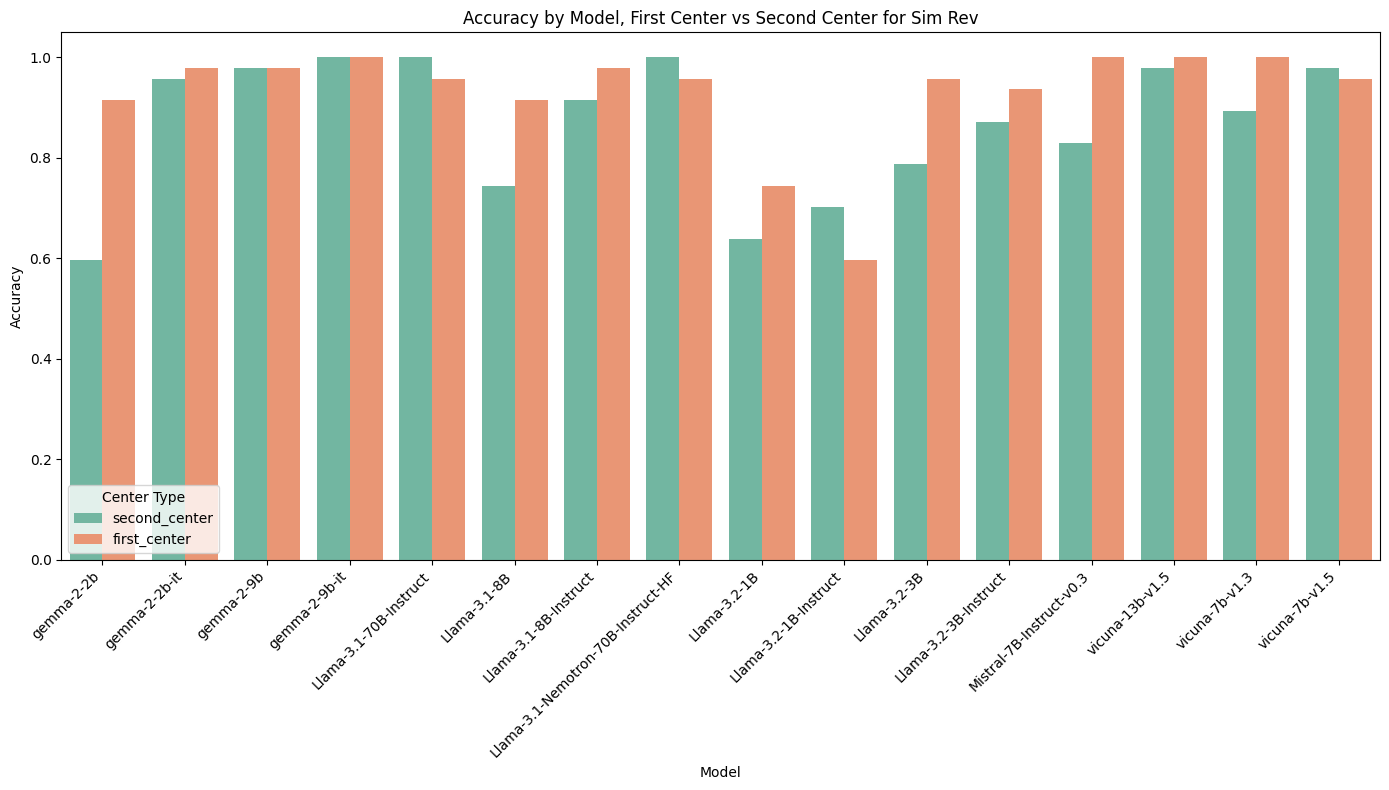

In [ ]:
# Plot for sim rev
sim_rev = accuracy_by_model_and_type_with_sim_rev[accuracy_by_model_and_type_with_sim_rev['wording'] == "sim_rev"]
plot_accuracy_per_model(sim_rev, title='Accuracy by Model, First Center vs Second Center for Sim Rev')


In [ ]:
sim_rev

,model,type,accuracy,center_type,wording
3,gemma-2-2b,first_center_sim_rev,0.914894,first_center,sim_rev
7,gemma-2-2b,second_center_sim_rev,0.595745,second_center,sim_rev
11,gemma-2-2b-it,first_center_sim_rev,0.978723,first_center,sim_rev
15,gemma-2-2b-it,second_center_sim_rev,0.957447,second_center,sim_rev
19,gemma-2-9b,first_center_sim_rev,0.978723,first_center,sim_rev
23,gemma-2-9b,second_center_sim_rev,0.978723,second_center,sim_rev
27,gemma-2-9b-it,first_center_sim_rev,1.000000,first_center,sim_rev
31,gemma-2-9b-it,second_center_sim_rev,1.000000,second_center,sim_rev
35,Llama-3.1-70B-Instruct,first_center_sim_rev,0.957447,first_center,sim_rev
39,Llama-3.1-70B-Instruct,second_center_sim_rev,1.000000,second_center,sim_rev


In [ ]:
def confidence_first_vs_second(all_data, isRight, wording=None):
  title_suffix = " (First vs Second)"
  if wording:
    all_data=all_data[all_data['wording'] == wording]
    title_suffix = f" {wording}".title()

  # Filter data for correct and incorrect predictions
  prob = 'correct_probability' if isRight else 'incorrect_probability'
  first_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['center_type'] == 'first_center')][['model', prob]]
  second_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['center_type'] == "second_center")][['model', prob]]


  # Rename columns for consistency in plotting
  first_data = first_data.rename(columns={prob: 'probability'})
  second_data = second_data.rename(columns={prob: 'probability'})

  # Add a column indicating the type of probability
  first_data['type'] = 'First'
  second_data['type'] = 'Second'

  # Combine the two datasets
  plot_data = pd.concat([first_data, second_data], ignore_index=True)

  plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the matplotlib figure
  plt.figure(figsize=(12, 8))

  # Create a boxplot
  sns.boxplot(
      data=plot_data,
      x='model',
      y='probability',
      hue='type',
      dodge=True,
      whis=[2,98]
  )
  is_right_title= "Right" if isRight else "Wrong"
  title= 'Confidence - Probability Distributions ' + is_right_title + title_suffix
  plt.title(title)
  plt.xlabel('Model')
  plt.ylabel('Probability')
  plt.legend(title='Type of Probability')
  plt.ylim(-0.05,1.02)
  plt.xticks(rotation=45, ha='right', fontsize=10)


  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)


  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()



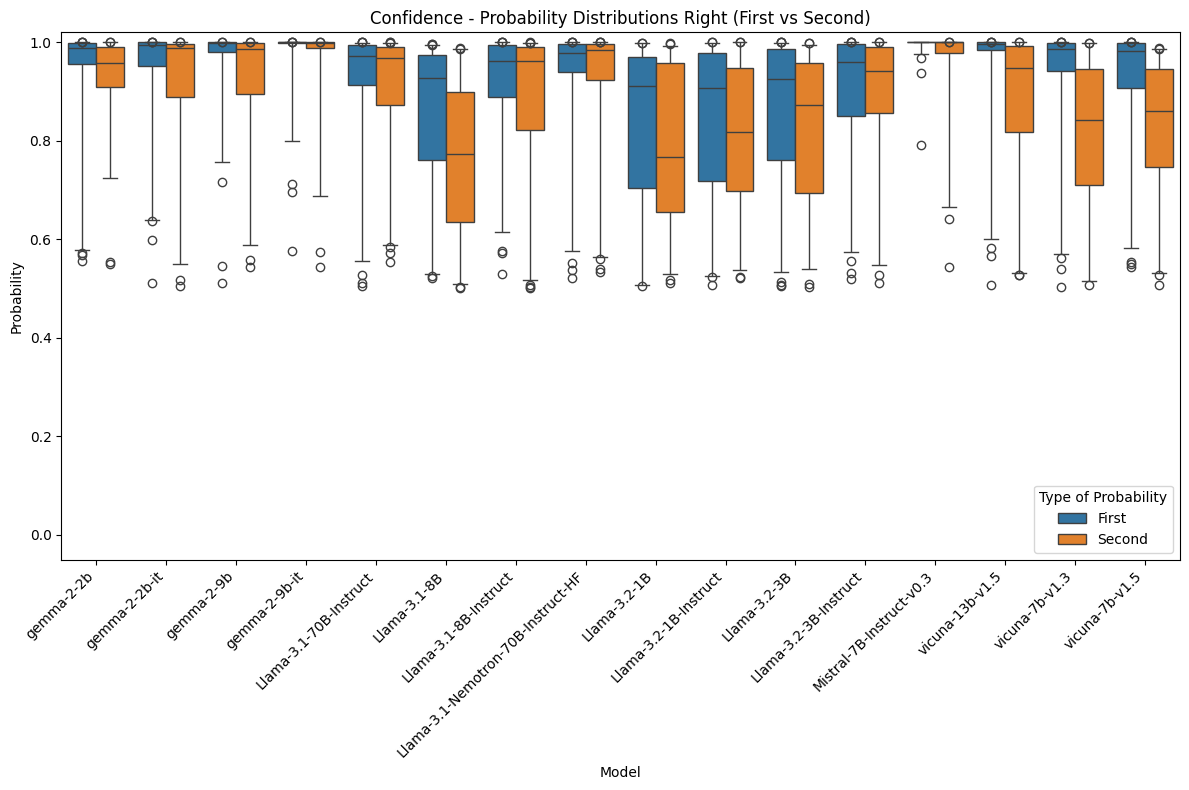

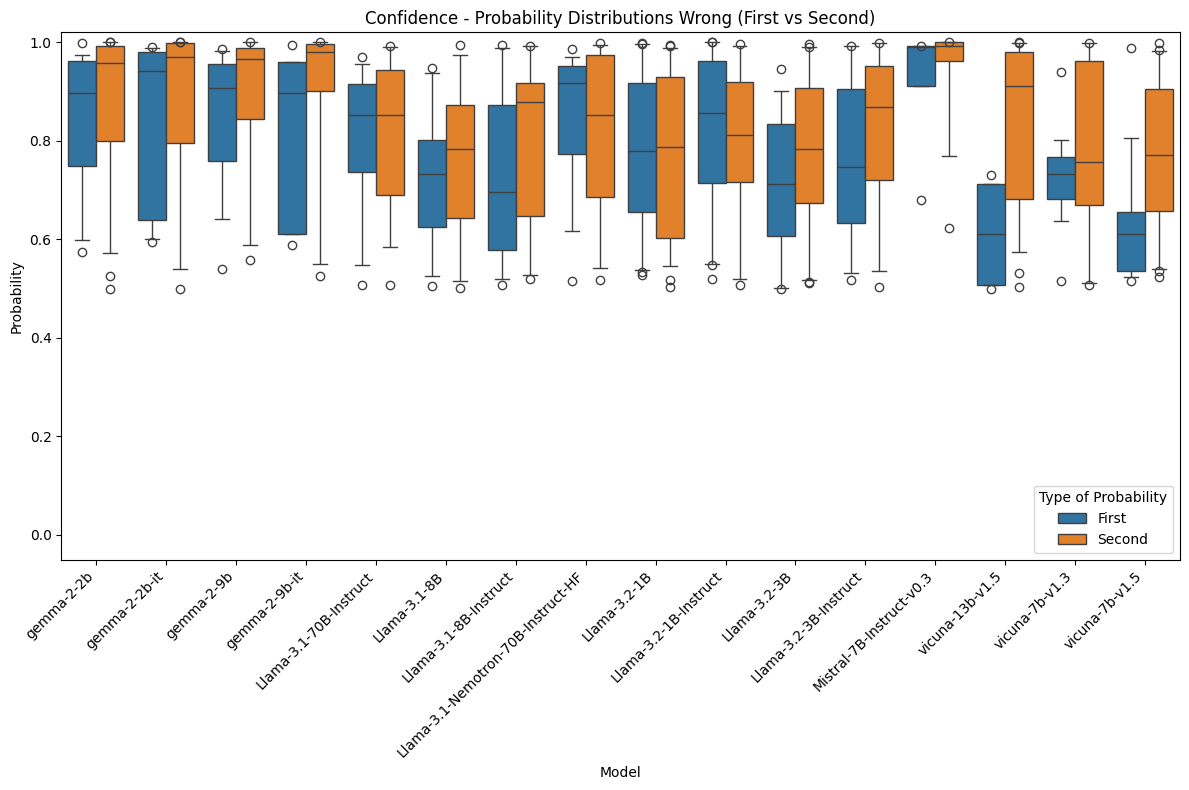

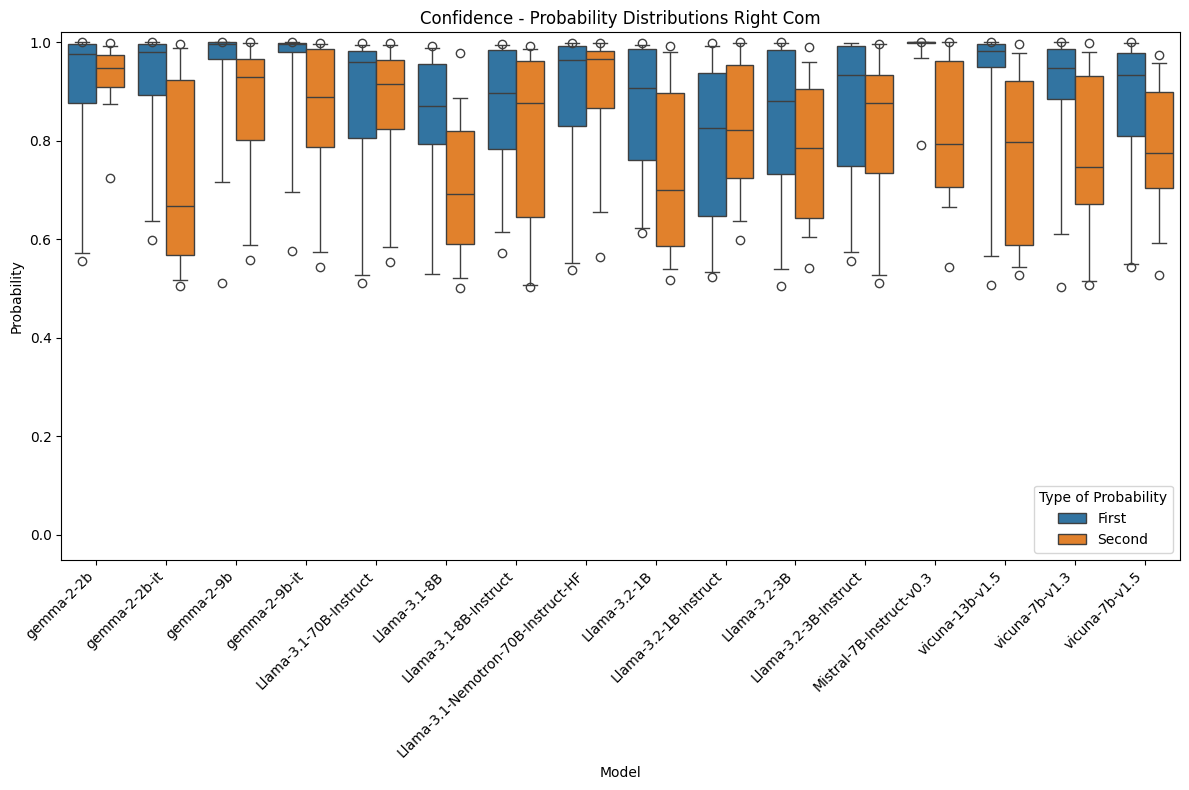

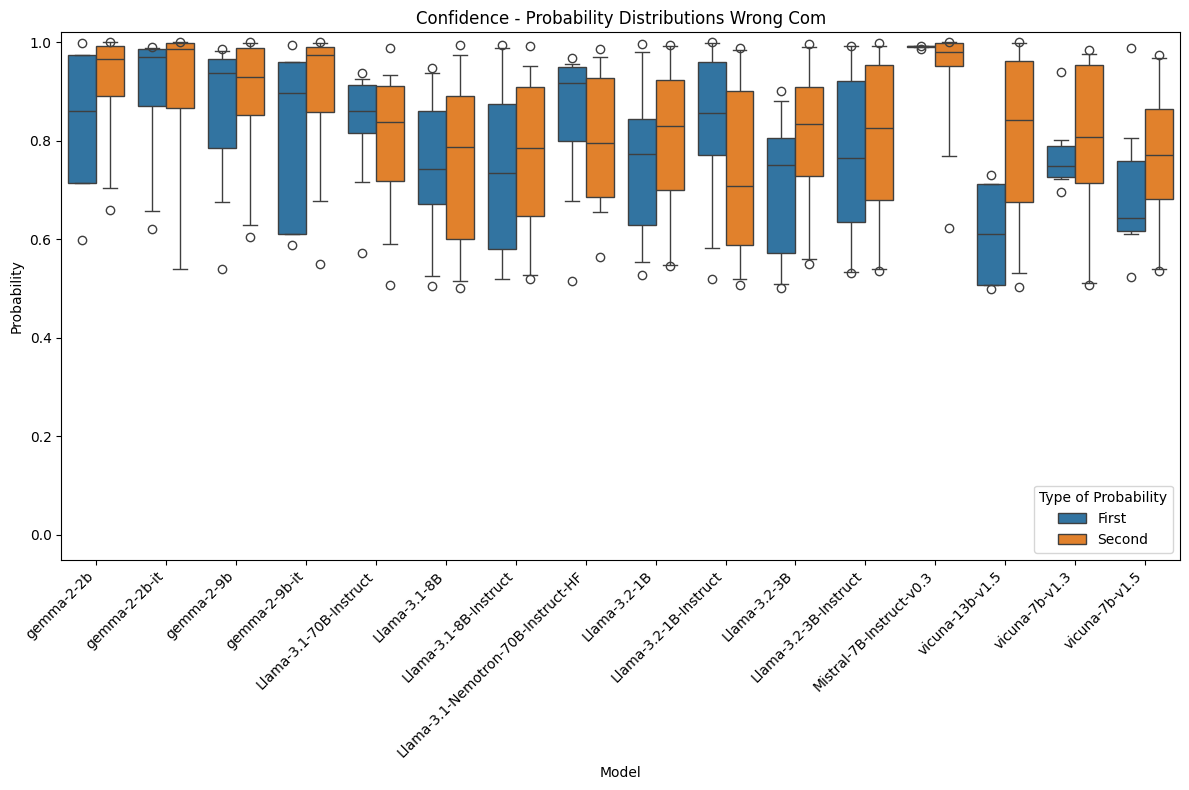

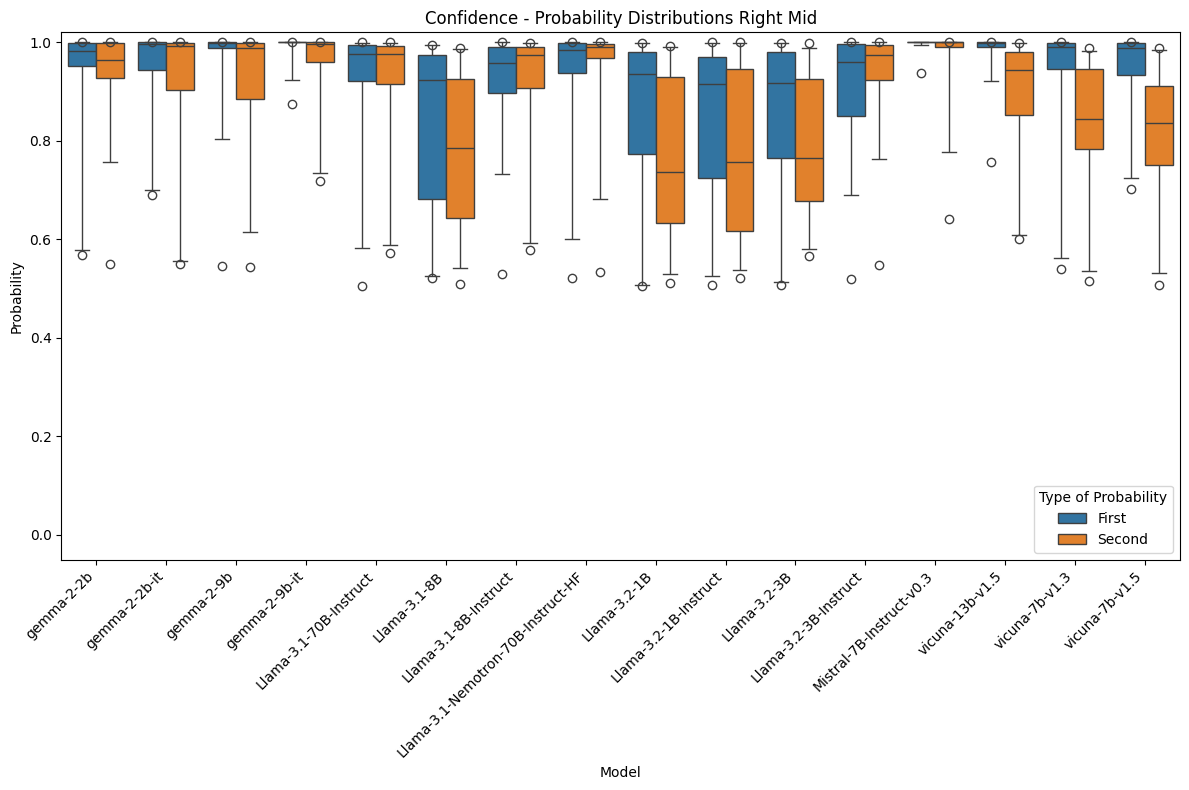

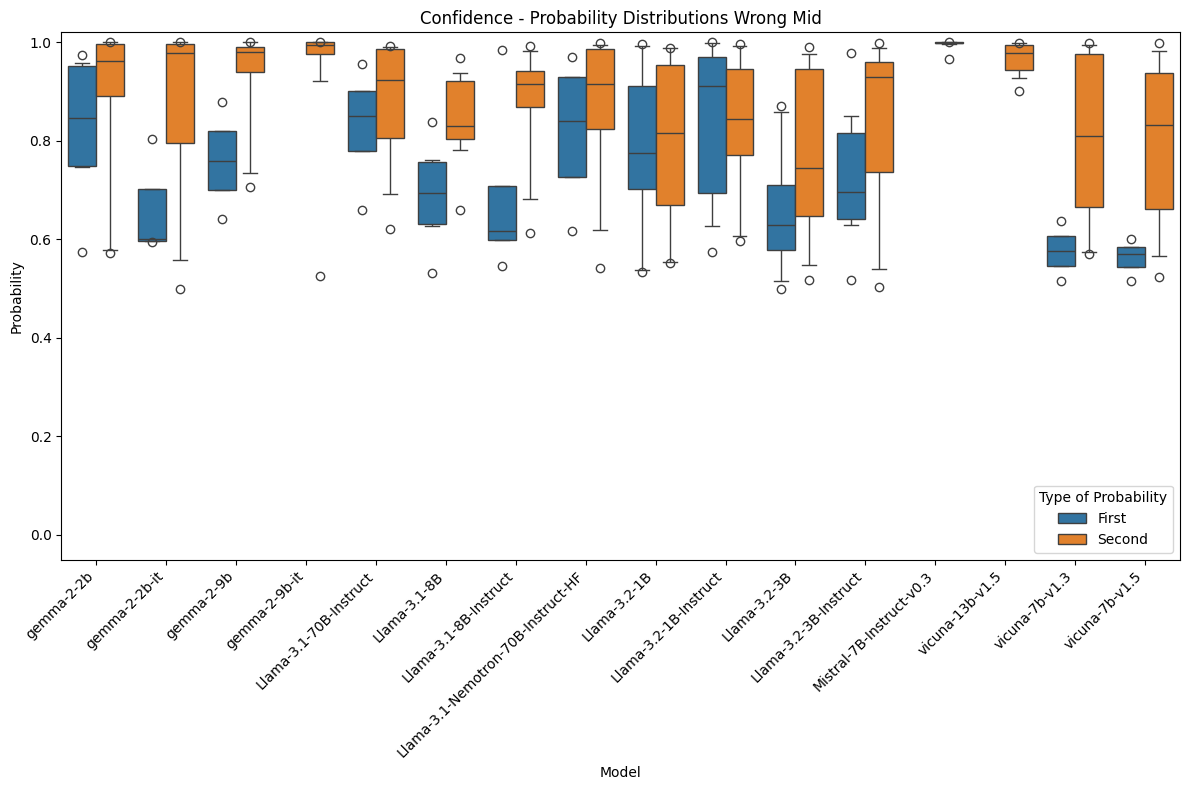

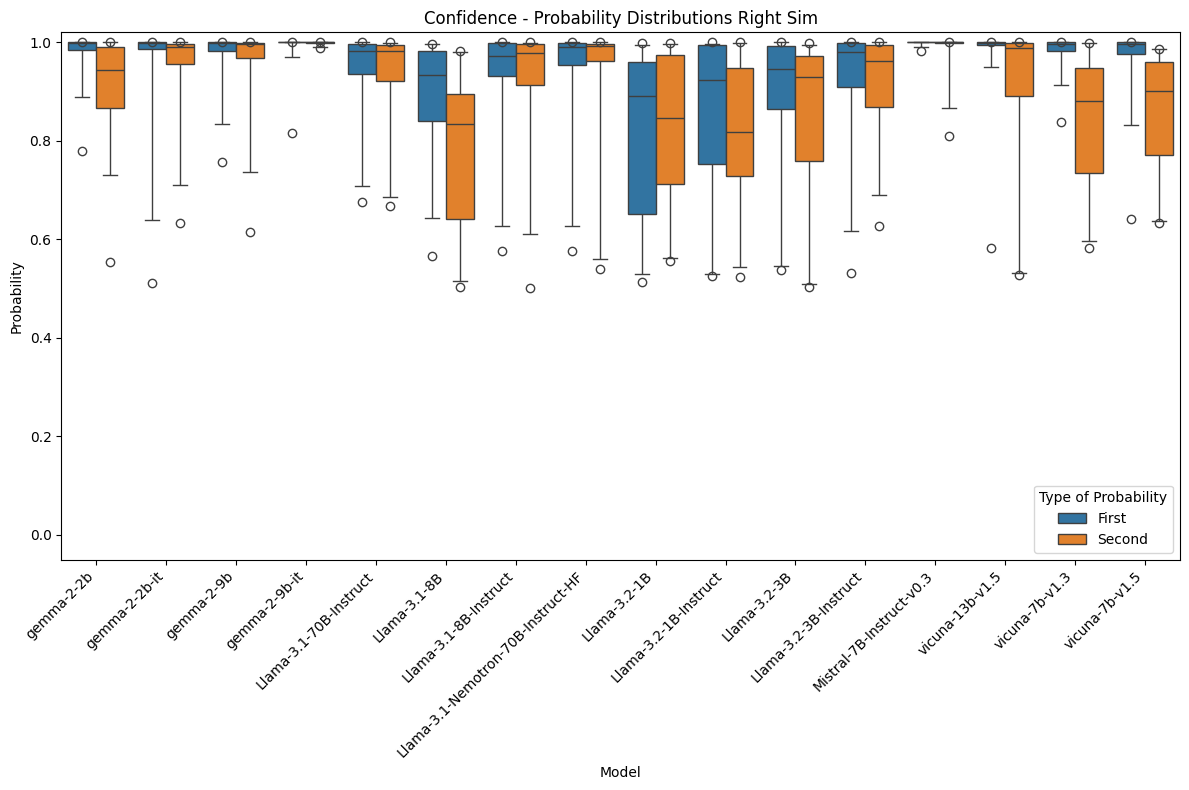

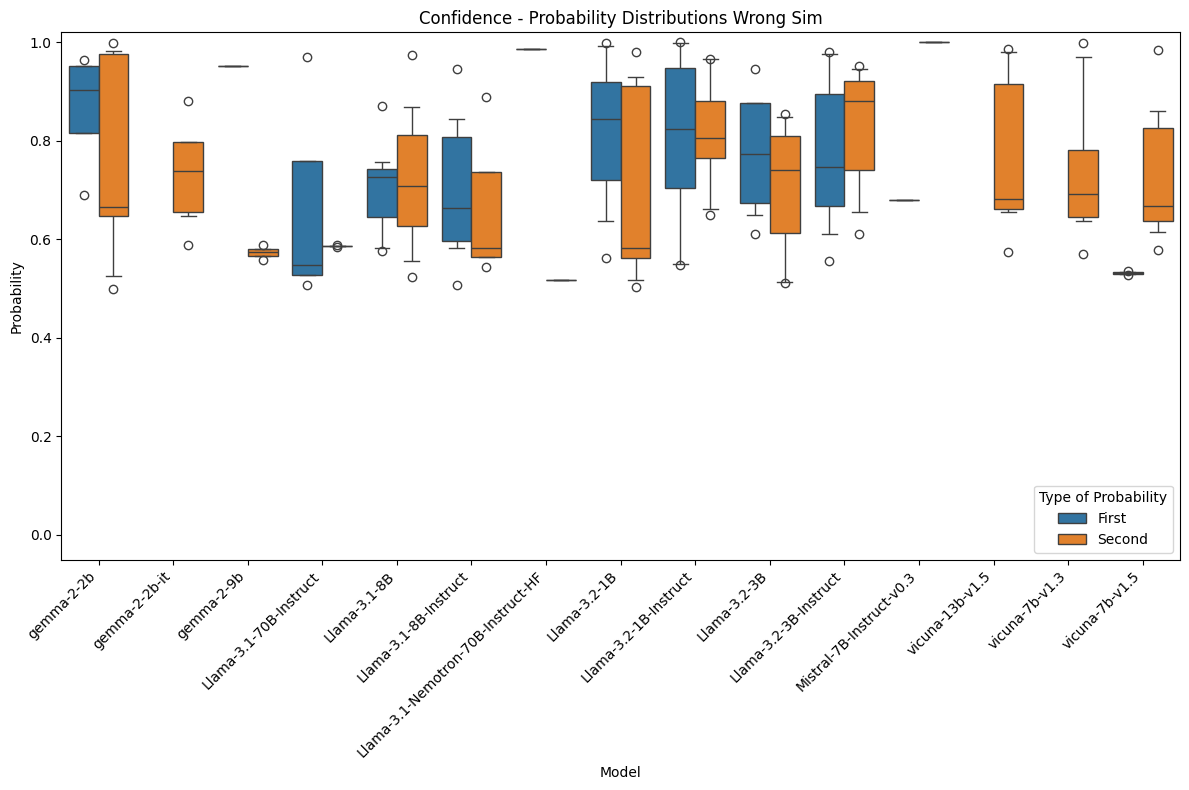

In [ ]:
confidence_first_vs_second(all_data, isRight=True, wording=None)
confidence_first_vs_second(all_data, isRight=False, wording=None)
confidence_first_vs_second(all_data, isRight=True, wording="com")
confidence_first_vs_second(all_data, isRight=False, wording="com")
confidence_first_vs_second(all_data, isRight=True, wording="mid")
confidence_first_vs_second(all_data, isRight=False, wording="mid")
confidence_first_vs_second(all_data, isRight=True, wording="sim")
confidence_first_vs_second(all_data, isRight=False, wording="sim")

## Statistical tests

In [ ]:
def print_to_screen_and_file(file_path, *args, **kwargs):
    # Print to the screen
    print(*args, **kwargs)

    # Open (or create) the file "CCC" in append mode
    with open(file_path + ".txt", "a") as file:
        print(*args, file=file, **kwargs)



In [ ]:
from scipy.stats import mannwhitneyu

def stat_test_com_vs_non_com(df, model_name, file_path):

  print_to_screen_and_file(file_path, f"Model name is: {model_name}")



  for i, t in enumerate(["right_all", "wrong_all", "first_center_right", "first_center_wrong", "second_center_right", "second_center_wrong"]):
      if t == "right_all":
        com = df[(df["wording"] =="com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        non_com = df[(~(df["wording"]=="com")) & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "non com has significantly larger values"
      elif t == "wrong_all":
        com = df[(df["wording"] =="com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        non_com = df[(~(df["wording"]=="com")) & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "non com has significantly lower values"
      # For wrong answers
      elif t == "first_center_right":
        com = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        non_com = df[(df["type"].isin(["first_center_mid", "first_center_sim", "first_center_sim_rev"])) & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "non com has significantly larger values"
      elif t == "first_center_wrong":
        com = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        non_com = df[(df["type"].isin(["first_center_mid", "first_center_sim", "first_center_sim_rev"])) & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "non com has significantly lower values"
      elif t == "second_center_right":
        com = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        non_com = df[(df["type"].isin(["second_center_mid", "second_center_sim", "second_center_sim_rev"])) & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "non com has significantly larger values"
      else:
        assert(t == "second_center_wrong")
        com = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        non_com = df[(df["type"].isin(["second_center_mid", "second_center_sim", "second_center_sim_rev"])) & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "non com has significantly lower values"



      print_to_screen_and_file(file_path, t.replace("_", " "))

      if com.empty or non_com.empty:
        print_to_screen_and_file(file_path, "Not enough data to perform test")
        print_to_screen_and_file(file_path, "")
        continue
      # Perform the Mann-Whitney U Test
      stat, p_value = mannwhitneyu(com, non_com, alternative=alternative)


      # Print the results

      print_to_screen_and_file(file_path, f"U-statistic: {stat}")
      print_to_screen_and_file(file_path, f"P-value: {p_value}")


      # Interpret the results
      alpha = 0.05
      if p_value < alpha:
          print_to_screen_and_file(file_path, f"Reject the null hypothesis: {hypothesis}.")
      else:
          print_to_screen_and_file(file_path, "Fail to reject the null hypothesis: No significant difference.")

      print_to_screen_and_file(file_path, "_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _")
      print_to_screen_and_file(file_path, "")

  print_to_screen_and_file(file_path, "________________________________________________________________________")
  print_to_screen_and_file(file_path, "")
      # Optional: Visualize the data
      #plt.hist(com, bins=20, alpha=0.5, label='com')
      #plt.hist(non_com, bins=20, alpha=0.5, label='non_com')
      #plt.legend(loc='upper right')
      #plt.xlabel('Probability')
      #plt.ylabel('Count')
      #plt.title('Distributions Comparison')
      #plt.show()


In [ ]:
file_path = os.path.join(res_dir, f"com_vs_non_com_statistic_test")
for model in all_data['model'].unique():
  stat_test_com_vs_non_com(all_data[all_data['model'] == model], model, file_path)

Model name is: gemma-2-2b
right all
U-statistic: 3018.0
P-value: 0.034661234212514366
Reject the null hypothesis: non com has significantly larger values.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

wrong all
U-statistic: 1220.0
P-value: 0.04357977535870708
Reject the null hypothesis: non com has significantly lower values.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

first center right
U-statistic: 1290.0
P-value: 0.00431613638406226
Reject the null hypothesis: non com has significantly larger values.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

first center wrong
U-statistic: 23.0
P-value: 0.36663336663336665
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

second center right
U-statistic: 231.0
P-value: 0.34849824725398354
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

second center wrong
U-statistic: 842.0
P-value: 0.10721490204188777
Fail to reject the null hypothesis: No significant differe

In [ ]:
from scipy.stats import mannwhitneyu

def stat_test_first_vs_second(df, model_name, file_path):

  print_to_screen_and_file(file_path, f"Model name is: {model_name}")



  for i, t in enumerate(["right_all", "wrong_all", "com_right", "com_wrong", "mid_right", "mid_wrong", "sim_right", "sim_wrong"]):
      if t == "right_all":
        first = df[(df["center_type"] =="first_center") & (df["is_correct_prediction"] == True)]["correct_probability"]
        second = df[(df["center_type"]=="second_center") & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      elif t == "wrong_all":
        first = df[(df["center_type"] =="first_center") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        second = df[(df["center_type"]=="second_center") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "first center has significantly lower values"
      # For wrong answers
      elif t == "com_right":
        first = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        second = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      elif t == "com_wrong":
        first = df[(df["type"] == "first_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        second = df[(df["type"] == "second_center_com") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "first center has significantly lower values"
      elif t == "mid_right":
        first = df[(df["type"] == "first_center_mid") & (df["is_correct_prediction"] == True)]["correct_probability"]
        second = df[(df["type"] == "second_center_mid") & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      elif t == "mid_wrong":
        first = df[(df["type"] == "first_center_mid") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        second = df[(df["type"] == "second_center_mid") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "first center has significantly lower values"
      elif t == "sim_right":
        first = df[(df["type"] == "first_center_sim") & (df["is_correct_prediction"] == True)]["correct_probability"]
        second = df[(df["type"] == "second_center_sim") & (df["is_correct_prediction"] == True)]["correct_probability"]
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      else:
        assert(t == "sim_wrong")
        first = df[(df["type"] == "first_center_sim") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        second = df[(df["type"] == "second_center_sim") & (df["is_correct_prediction"] == False)]["incorrect_probability"]
        alternative = "greater"
        hypothesis = "first center has significantly lower values"



      print_to_screen_and_file(file_path, t.replace("_", " "))

      if first.empty or second.empty:
        print_to_screen_and_file(file_path, "Not enough data to perform test")
        print_to_screen_and_file(file_path, "")
        continue
      # Perform the Mann-Whitney U Test
      #stat, p_value = mannwhitneyu(com, non_com, alternative=alternative)
      stat, p_value = mannwhitneyu(second, first, alternative=alternative)


      # Print the results

      print_to_screen_and_file(file_path, f"U-statistic: {stat}")
      print_to_screen_and_file(file_path, f"P-value: {p_value}")


      # Interpret the results
      alpha = 0.05
      if p_value < alpha:
          print_to_screen_and_file(file_path, f"Reject the null hypothesis: {hypothesis}.")
      else:
          print_to_screen_and_file(file_path, "Fail to reject the null hypothesis: No significant difference.")

      print_to_screen_and_file(file_path, "_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _")
      print_to_screen_and_file(file_path, "")

  print_to_screen_and_file(file_path, "________________________________________________________________________")
  print_to_screen_and_file(file_path, "")
      # Optional: Visualize the data
      #plt.hist(com, bins=20, alpha=0.5, label='com')
      #plt.hist(non_com, bins=20, alpha=0.5, label='non_com')
      #plt.legend(loc='upper right')
      #plt.xlabel('Probability')
      #plt.ylabel('Count')
      #plt.title('Distributions Comparison')
      #plt.show()


In [ ]:
file_path = os.path.join(res_dir, f"first_vs_second_statistic_test")
for model in all_data['model'].unique():
  stat_test_first_vs_second(all_data[all_data['model'] == model], model, file_path)

Model name is: gemma-2-2b
right all
U-statistic: 2880.0
P-value: 0.0003104243937560109
Reject the null hypothesis: first center has significantly larger values.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

wrong all
U-statistic: 676.5
P-value: 0.054452972428288976
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

com right
U-statistic: 159.0
P-value: 0.20542340563764117
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

com wrong
U-statistic: 96.0
P-value: 0.20167722138944166
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

mid right
U-statistic: 389.0
P-value: 0.18761394599473397
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

mid wrong
U-statistic: 103.0
P-value: 0.08682282987066078
Fail to reject the null hypothesis: No significant difference.
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _



## Download results

In [ ]:
import shutil
from google.colab import files

In [ ]:
# Replace 'folder_path' with the path to the folder you want to download
folder_path = res_dir
zip_file_path = f'/content/results.zip'

# Zip the folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

# Download the zip file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
shutil.rmtree(f"/{res_dir}")